## Arbeitsschritte

Was ich erwarte:
* Daten laden ###
* Erste “Insights”, d.h. explorative Datenanalayse inkl. einiger Charts (Verteilungen, erste Korrelationen etc.,) um die Daten zu verstehen ###
* Datacleaning ###
* Feature Engineering ###
* Modellbildung
* alle klassischen Modelle, die Sie bisher kennen
* XGBoost ###
* Neuronales Netz ###
* Für die besten Modelle: Hyperparameter Tuning (GridSearchCV) ###
* ggf. auch Mischung verschiedener Modelle (Ensemble) ###
* Feature Importance / Permutation Importance ###
* Eine Submission soll für die test.csv erstellt werden und bei Kaggle hochgeladen werden
* Am Ende zwei reißerische Grafiken mit jeweils einer Einsicht auf Basis der KI-Modelle (storytelling beachten!)
* Für jedes Kapitel eine kurze (gerne stichwortartige) Zusammenfassung im Notebook, was gemacht bzw. was noch so versucht wurde, jedoch nicht geklappt hat und welche Erkentnisse im Kapitel gesammelt wurden.


Organisatorisches:

* Abgabe
* Form eines Git-Links zu Ihrem Projekt
* Montag 08.04.. , 23:59 Uhr
* Sie haben in meinem Unterricht zwei Termine Zeit für diesen Teil (12.02. und 19.02.)

# Mies viele Kommentare

# One Hot Encoden ??? markdownzelle mit begründung warum nicht verwendet

# auf rmspe score bei ML umstellen

# in best p.py grobe idee erklären und ablauf

# device wahl für torch automatisch

# bei prediction mit NN prediction mit e^x verrechnen wegen log(sales)

# Daten Laden und zusammenführen

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import re
from best_params import make # importiert die Funktion make aus der Datei best_params.py um die besten Parameter für die ML-Verfahren zu finden
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
import torch
import torch.nn as nn
import json
import seaborn as sns
import xgboost
import numpy as np

# Die Hauptdaten und weitere Informationen zu einzelnen Geschäften laden
df = pd.read_csv("train.csv")
store_df = pd.read_csv("store.csv")

# Zusatzinformation der einzelnen Geschäfte in den Haupt DataFrame laden
big_df = df.merge(store_df, on="Store", how="left")
store_df

C:\Users\ole\AppData\Local\Temp\ipykernel_9504\3004666315.py:23: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("train.csv")


,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1110,1111,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1111,1112,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1113,1114,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


## EDA

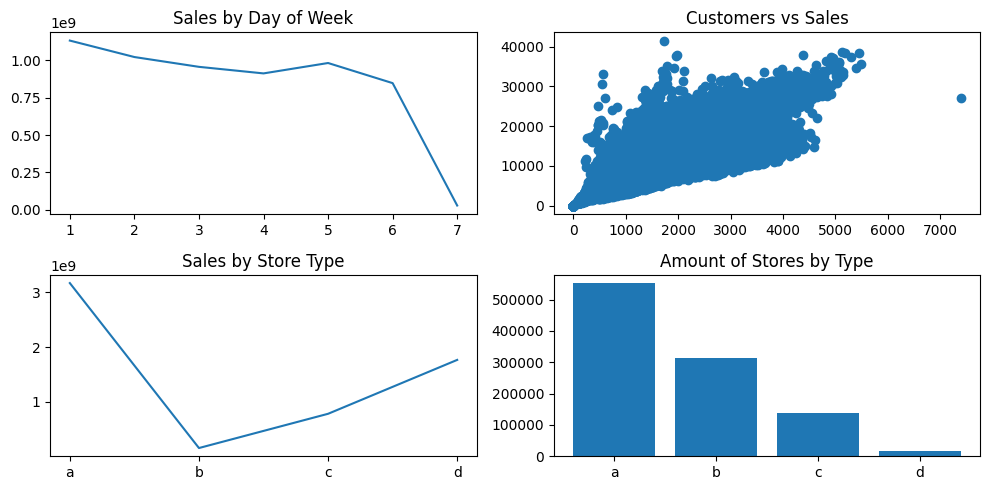

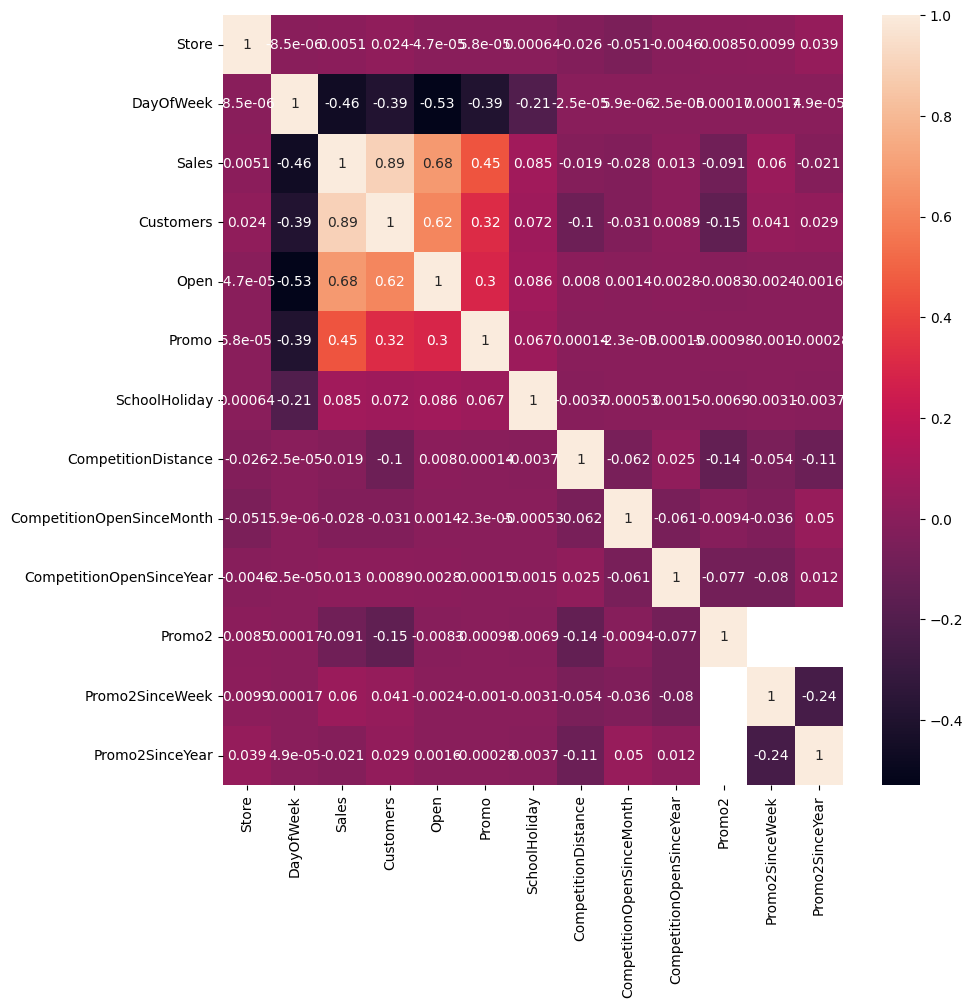

In [16]:
fig, axs = plt.subplots(2, 2, figsize=(10, 5))

# Plot 1: Sales by Day of WeekVerkäufe nach Wochentag 
s_b_d = big_df["Sales"].groupby(big_df["DayOfWeek"]).sum()
axs[0, 0].plot(s_b_d)
axs[0, 0].set_title('Sales by Day of Week')

# Plot 2: Punktwolke mit Vergleich zwischen Customers und Sales 
axs[0, 1].scatter(big_df["Customers"], big_df["Sales"])
axs[0, 1].set_title('Customers vs Sales')

# Plot 3: Verkäufe nach Geschäftsart 
sales_by_storeType = big_df["Sales"].groupby(big_df["StoreType"]).sum()
axs[1, 0].plot(sales_by_storeType)
axs[1, 0].set_title('Sales by Store Type')

# Plot 4: Anzahl der Geschäfte nach Typ 
amt_stores_by_type = big_df["StoreType"].value_counts()
axs[1, 1].bar(["a", "b", "c", "d"], amt_stores_by_type)
axs[1, 1].set_title('Amount of Stores by Type')

# Durchschnittliche Käufe pro Kunde
#sales_per_customer = big_df["Sales"] / big_df["Customers"]
#big_df["sales_per_customer"] = sales_per_customer

# Durchschnittliche Käufe pro Kunde nach Store Type
#m_sales_customer_by_st = big_df["sales_per_customer"].groupby(big_df["StoreType"]).sum().values.tolist()
#axs[2, 0].plot(big_df["StoreType"].unique(), m_sales_customer_by_st)
#axs[2, 0].set_title("mean_sales_p_cust_by_stoTyp")

# Grafiken ausgeben
plt.tight_layout()
plt.show()

# Für den Korrelationschart nur numerische Werte einbeziehen
numeric_cols = big_df.select_dtypes(include=[np.number])
corr = numeric_cols.corr()
plt.figure(figsize=(10, 10))
sns.heatmap(corr, annot=True)
plt.show()

### Zusammenfassung EDA Phase

* Plots
    * Store Typ A ist am häufigsten vorhanden und hat die höchsten Verkaufswerte
    * Die Sales sind Montags am höchsten
* Korrelation
    * Es gibt eine sehr stark positive Korrelation zwischen Sales & Customers
    * Es gibt eine mittlere negative Korrelation zwischen DayOfWeek & Open

Die letzten beiden Plots haben wir nicht erstellt, da die Test-Daten keine Informationen zu den Customern enthalten und somit obsolet sind

## Datacleaning

In [17]:
def apply_cleaning(df, test=True):
    # Leere Werte der Spalte Competition Distance mit -1 füllen
    df["CompetitionDistance"] = df["CompetitionDistance"].fillna(-1)

    # Zeilen finden in welchen "CompetitionDistance" gleich -1 ist
    comp_zeros = df["CompetitionDistance"] == -1

    # Setze "CompetitionOpenSinceMonth" und "CompetitionOpenSinceYear" auf -1 für diese Zeilen
    df["CompetitionOpenSinceMonth"][comp_zeros] = -1
    df["CompetitionOpenSinceYear"][comp_zeros] = -1

    # Entferne alle Zeilen mit NaN-Werten aus dem DataFrame
    if not test:
        df = df.dropna(axis=0)
    else :
        df = df.fillna(0, axis=0)
    return df

# Die Bereinigung auf den Haupt-DataFrame anwenden 
big_df = apply_cleaning(big_df)
big_df.head(5)

C:\Users\ole\AppData\Local\Temp\ipykernel_9504\2914936506.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["CompetitionOpenSinceMonth"][comp_zeros] = -1
C:\Users\ole\AppData\Local\Temp\ipykernel_9504\2914936506.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["CompetitionOpenSinceYear"][comp_zeros] = -1


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,0.0,0.0,0
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,0.0,0.0,0


In [18]:
# Datum reicht von 2015-07-31 bis 2013-01-01
big_df["Date"].unique()

array(['2015-07-31', '2015-07-30', '2015-07-29', '2015-07-28',
       '2015-07-27', '2015-07-26', '2015-07-25', '2015-07-24',
       '2015-07-23', '2015-07-22', '2015-07-21', '2015-07-20',
       '2015-07-19', '2015-07-18', '2015-07-17', '2015-07-16',
       '2015-07-15', '2015-07-14', '2015-07-13', '2015-07-12',
       '2015-07-11', '2015-07-10', '2015-07-09', '2015-07-08',
       '2015-07-07', '2015-07-06', '2015-07-05', '2015-07-04',
       '2015-07-03', '2015-07-02', '2015-07-01', '2015-06-30',
       '2015-06-29', '2015-06-28', '2015-06-27', '2015-06-26',
       '2015-06-25', '2015-06-24', '2015-06-23', '2015-06-22',
       '2015-06-21', '2015-06-20', '2015-06-19', '2015-06-18',
       '2015-06-17', '2015-06-16', '2015-06-15', '2015-06-14',
       '2015-06-13', '2015-06-12', '2015-06-11', '2015-06-10',
       '2015-06-09', '2015-06-08', '2015-06-07', '2015-06-06',
       '2015-06-05', '2015-06-04', '2015-06-03', '2015-06-02',
       '2015-06-01', '2015-05-31', '2015-05-30', '2015-

### Zusammenfassung Datacleaning Phase

* Leere und Fehlerhafte Daten werden entfernt bzw. mit Flag-Werten aufgefüllt

## Feature Engineering

In [19]:
def do_fe(df):
    
    # Aus der Spalte Date das Jahr und den Monat extrahieren, diese in Integer umwandeln und um ihr Minimum reduzieren
    df["year"] = df["Date"].str.split("-").str[0]
    df["month"] = df["Date"].str.split("-").str[1]
    df["year"] = df["year"].astype(int) - 2013
    df["month"] = df["month"].astype(int) - 1
    to_drop = ["Date", "Store"]
    df = df.drop(to_drop, axis=1)

    # Anpassung der Datentypen auf Integer, sodass diese von den ML-Verfahren verarbeitet werden können
    df["CompetitionDistance"] = df["CompetitionDistance"].astype(int)

    df["CompetitionOpenSinceMonth"] = df["CompetitionOpenSinceMonth"].fillna(0).astype(int).astype(int)

    df["CompetitionOpenSinceYear"] = df["CompetitionOpenSinceYear"].fillna(0).astype(int)
    
    
    df["Promo2SinceWeek"] = df["Promo2SinceWeek"].astype(int)
    df["Promo2SinceYear"] = df["Promo2SinceYear"].astype(int)

    # Die Storytypen und Sortimentenart in eine numerischen Skalierung überführen 
    store_type_dict = {"a": 0, "b": 1, "c": 2, "d": 3}
    df["StoreType"] = df["StoreType"].map(store_type_dict)
    assortment_dict = {"a": 0, "b": 1, "c": 2}
    df["Assortment"] = df["Assortment"].map(assortment_dict)

    # Die Spalte Promo Intervall enthält 3 Unique Werte. 
    # Um zu verhindern, Das eine Wertigkeit erlernt wird, haben wir uns dazu entschieden Für jeden Monat eine Spalte anzulegen.
    # Alle Spalten werden bei Erstellung mit Nullen gefüllt. Dann wird über die Elemente der Spalte PromoIntervall itteriert und je nach einem der 3 Fälle, 
    # die entsprechenden Zellen der entsprechenden Spalten mit Einsen gefüllt (Beim Januar also die Zellen der Spalten Januar April, Juli und Oktober).
    df["jan"] = 0
    df["feb"] = 0
    df["mar"] = 0
    df["apr"] = 0
    df["may"] = 0
    df["jun"] = 0
    df["jul"] = 0
    df["aug"] = 0
    df["sep"] = 0
    df["oct"] = 0
    df["nov"] = 0
    df["dec"] = 0

    for index, row in df.iterrows():
        start = str(row["PromoInterval"]).split(",")[0]
        match start:
            case "Jan":
                df.at[index, "jan"] = 1
                df.at[index, "apr"] = 1
                df.at[index, "jul"] = 1
                df.at[index, "oct"] = 1

            case "Feb":
                df.at[index, "feb"] = 1
                df.at[index, "may"] = 1
                df.at[index, "aug"] = 1
                df.at[index, "nov"] = 1

            case "Mar":
                df.at[index, "mar"] = 1
                df.at[index, "jun"] = 1
                df.at[index, "sep"] = 1
                df.at[index, "dec"] = 1

    df = df.drop("PromoInterval", axis=1)   

    # Alle Spaltentitel in lower Snake Case umwandeln
    for col in df.columns:
        col_n = re.sub(r'(?<!^)(?=[A-Z])', '_', col).lower()
        df.rename(columns={col: col_n}, inplace=True)

    # Feiertage in numerische Werte umwandeln und mit Wertigkeit versehen - 0 für keine Feiertage, 1 für Feiertage, 2 für Ostern, 3 für Weihnachten
    holiday_map = {"0": 0, "a": 1, "b": 2, "c": 3, 0: 0}
    df["state_holiday"] = df["state_holiday"].map(holiday_map)

    # Da in diesen Spalten im Vergleich zu den anderen des DataFrames sehr hohe Werte vorkommen, haben wir uns dazu entschlossen, den natürlichen Logarithmus der jeweiligen Spalte zu ziehen, damit die Modelle vernünftig lernen können
    try:
        df["sales"] = np.log(df["sales"])
    except:
        pass
    try:
        #df["customers"] = np.log(df["customers"]) # Diese Spalte kann für Vorhersagen nicht verwendet werden, da sie nicht im Test-Set enthalten ist
        df = df.drop("customers", axis=1)
    except:
        pass
    df["competition_distance"] = np.log(df["competition_distance"])

    return df

big_df = do_fe(big_df)
big_df

C:\Users\ole\AppData\Roaming\Python\Python311\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\ole\AppData\Roaming\Python\Python311\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,day_of_week,sales,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,...,mar,apr,may,jun,jul,aug,sep,oct,nov,dec
0,5,8.568456,1,1,0,1,2,0,7.146772,9,...,0,0,0,0,0,0,0,0,0,0
1,5,8.710125,1,1,0,1,0,0,6.345636,11,...,0,1,0,0,1,0,0,1,0,0
2,5,9.025696,1,1,0,1,0,0,9.556055,12,...,0,1,0,0,1,0,0,1,0,0
3,5,9.546455,1,1,0,1,2,2,6.429719,9,...,0,0,0,0,0,0,0,0,0,0
4,5,8.480944,1,1,0,1,0,0,10.305948,4,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,2,-inf,0,0,1,1,0,0,7.549609,6,...,0,1,0,0,1,0,0,1,0,0
1017205,2,-inf,0,0,1,1,2,2,7.539027,4,...,0,0,0,0,0,0,0,0,0,0
1017206,2,-inf,0,0,1,1,0,2,9.133459,0,...,0,0,0,0,0,0,0,0,0,0
1017207,2,-inf,0,0,1,1,0,2,6.768493,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
#print(big_df["PromoInterval"].unique()) # im 3-Monats Intervall
big_df.columns

Index(['day_of_week', 'sales', 'open', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'year', 'month', 'jan', 'feb',
       'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec'],
      dtype='object')

### Zusammenfassung Feature Engineering Phase

* Daten für Diagramme
* Daten für ML-Verfahren
* Manuelles Label-Encoding
* Switch-Case um die Unterscheidung der einzelnen Monate im Bezug auf die Promophase zu garantieren und lernbar zu machen

# Modellbildung ML-Verfahren

In [21]:
# Haupt-DataFrame in Input- und Ergebniss-Daten Trennen
X = big_df.drop("sales", axis=1)
y = big_df["sales"]

# (negativ) unendliche Werte mit Nan und anschließend mit 0 füllen
X.replace([np.inf, -np.inf], np.nan, inplace=True)
X.fillna(0, inplace=True)
y.replace([np.inf, -np.inf], np.nan, inplace=True)
y.fillna(0, inplace=True)

# Die Daten Normalisieren
scaler=StandardScaler()
scaler.fit(X)
x_scaled=scaler.transform(X)

x_scaled_df = pd.DataFrame(x_scaled, columns=X.columns)

# Die Daten in Trainings- und Testdaten aufteilen
X_train, X_test, y_train, y_test = train_test_split(x_scaled_df, y, test_size=0.2, random_state=42, shuffle=True)

# Die Funktion make kann aufgerufen werden, um die optimalen Parameter für die Machine Learning-Verfahren zu errechnen und in eine json-Datei zu speichern
# print("MAKE IS STARTING")
# make(X_train, y_train)
# print("MAKE IS DONE")

In [22]:
# Die besten Parameter aus der json-Datei laden
params_f = json.load(open("best_params.json", "r"))

def make_voting(X_train, y_train, X_test, y_test):
    # Das jeweilige Dictionary mit dem Parametern für das jeweilige Verfahren herausnehmen
    best_knn_params = params_f["knn"]
    best_tree_params = params_f["tree"]
    best_forest_params = params_f["forest"]
    #best_svm_params = params_f["svm"]
    #best_lin_reg_params = params_f["lin_reg"]
    best_xg_params = params_f["xg"]
    best_adaboost_params = params_f["adaboost"]
    best_gradientboost_params = params_f["gradientboost"]

    # Je Parameter Dictionary ein Vorhersagemodell aus diesen Daten bauen
    knn = KNeighborsRegressor(n_neighbors=best_knn_params["kneighborsregressor__n_neighbors"],
                             weights=best_knn_params["kneighborsregressor__weights"],
                             algorithm=best_knn_params["kneighborsregressor__algorithm"])
    tree = DecisionTreeRegressor(max_depth=best_tree_params["decisiontreeregressor__max_depth"],
                                 min_samples_split=best_tree_params["decisiontreeregressor__min_samples_split"],
                                 min_samples_leaf=best_tree_params["decisiontreeregressor__min_samples_leaf"])
    forest = RandomForestRegressor(n_estimators=best_forest_params["randomforestregressor__n_estimators"],
                                   max_depth=best_forest_params["randomforestregressor__max_depth"],
                                   min_samples_split=best_forest_params["randomforestregressor__min_samples_split"],
                                   min_samples_leaf=best_forest_params["randomforestregressor__min_samples_leaf"])
    #svm = SVR(kernel=best_svm_params["svr__kernel"],
    #        degree=best_svm_params["svr__degree"],
    #        C=best_svm_params["svr__C"])
    #lin_reg = LinearRegression(fit_intercept=best_lin_reg_params["linearregression__fit_intercept"])
    xg = xgboost.XGBRegressor(learning_rate=best_xg_params["xgbregressor__learning_rate"],
                            max_depth=best_xg_params["xgbregressor__max_depth"],
                            n_estimators=best_xg_params["xgbregressor__n_estimators"])
    adaboost = AdaBoostRegressor(n_estimators=best_adaboost_params["adaboostregressor__n_estimators"],
                             learning_rate=best_adaboost_params["adaboostregressor__learning_rate"])
    gradientboost = GradientBoostingRegressor(n_estimators=best_gradientboost_params["gradientboostingregressor__n_estimators"],
                                          learning_rate=best_gradientboost_params["gradientboostingregressor__learning_rate"],
                                          max_depth=best_gradientboost_params["gradientboostingregressor__max_depth"])

    
    # Die Testdaten laden und auf dieselbe Weise transformieren wie die Trainingsdaten (Bereinigung und Feature Engineering)
    test_df = pd.read_csv("test.csv")
    test_df = test_df.merge(store_df, on="Store", how="left")
    test_df = apply_cleaning(test_df)
    test_df = do_fe(test_df)

    # Die IDs der Testdaten speichern und die Spalte aus dem DataFrame entfernen
    ids = [i+1 for i in range(len(test_df["id"]))]
    test_df = test_df.drop("id", axis=1)

    # (negative) unendliche Werte mit Nan und anschließend mit 0 füllen
    test_df.replace([np.inf, -np.inf], np.nan, inplace=True)
    test_df.fillna(0, inplace=True)

    # Die Machine Learning Modelle auf die Daten trainieren, ihren MSE-Score ausgeben und die Vorhersagen in separaten csv-Dateien abspeichern 
    knn.fit(X_train, y_train)
    print("knn done")
    print(mean_squared_error(y_test, knn.predict(X_test)))
    knn_pred = knn.predict(test_df)
    knn_df = pd.DataFrame({"Id": ids, "Sales": np.exp(knn_pred)})
    knn_df.to_csv("knn.csv", index=False)
    del knn_df

    tree.fit(X_train, y_train)
    print("tree done")
    print(mean_squared_error(y_test, tree.predict(X_test)))
    tree_pred = tree.predict(test_df)
    tree_df = pd.DataFrame({"Id": ids, "Sales": np.exp(tree_pred)})
    tree_df.to_csv("tree.csv", index=False)
    del tree_df

    forest.fit(X_train, y_train)
    print("forest done")
    print(mean_squared_error(y_test, forest.predict(X_test)))
    forest_pred = forest.predict(test_df)
    forest_df = pd.DataFrame({"Id": ids, "Sales": np.exp(forest_pred)})
    forest_df.to_csv("forest.csv", index=False)
    del forest_df

    # svm.fit(X_train, y_train)
    # print("svm done")
    # print(mean_squared_error(y_test, svm.predict(X_test)))
    # svm_pred = svm.predict(test_df)
    # svm_df = pd.DataFrame({"Id": ids, "Sales": np.exp(svm_pred)})
    # svm_df.to_csv("svm.csv", index=False)
    # del svm_df

    #lin_reg.fit(X_train, y_train)
    #print("lin_reg done")
    #print(mean_squared_error(y_test, lin_reg.predict(X_test)))
    
    xg.fit(X_train, y_train)
    print("xg done")
    print(mean_squared_error(y_test, xg.predict(X_test)))
    xg_pred = xg.predict(test_df)
    xg_df = pd.DataFrame({"Id": ids, "Sales": np.exp(xg_pred)})
    xg_df.to_csv("xg.csv", index=False)
    del xg_df

    adaboost.fit(X_train, y_train)
    print("adaboost done")
    print(mean_squared_error(y_test, adaboost.predict(X_test)))
    adaboost_pred = adaboost.predict(test_df)
    adaboost_df = pd.DataFrame({"Id": ids, "Sales": np.exp(adaboost_pred)})
    adaboost_df.to_csv("adaboost.csv", index=False)
    del adaboost_df

    gradientboost.fit(X_train, y_train)
    print("gradientboost done")
    print(mean_squared_error(y_test, gradientboost.predict(X_test)))
    gradientboost_pred = gradientboost.predict(test_df)
    gradientboost_df = pd.DataFrame({"Id": ids, "Sales": np.exp(gradientboost_pred)})
    gradientboost_df.to_csv("gradientboost.csv", index=False)
    del gradientboost_df

    # Einen VotingRegressor aus den am besten performenden Modellen bauen und auf die Daten trainieren
    voting = VotingRegressor(estimators=[("knn", knn), ("tree", tree), ("forest", forest), ("xg", xg), ("adaboost", adaboost), ("gradientboost", gradientboost)])
    voting.fit(X_train, y_train)
    print("voting done")

    # Den Mean Squared Error ausgeben
    error = mean_squared_error(y_test, voting.predict(X_test))
    print("ERROR:", error)

    # Die Feature importance vom Voting errechnen und anzeigen
    # feature_importance = voting.feature_importances_
    # plt.barh(X_train.columns, feature_importance)
    # plt.show()

    # Access feature importances (if available)
    for name, estimator in voting.named_estimators_.items():
        if hasattr(estimator, 'feature_importances_'):
            print(f"{name} feature importances: {estimator.feature_importances_}")
    
    voting_pred = voting.predict(test_df)
    v_df = pd.DataFrame({"Id": ids, "Sales": voting_pred})
    v_df.to_csv("voting.csv", index=False)
    del v_df
    
    return voting

#vot = make_voting(X_train, y_train, X_test, y_test)

### Zusammenfassung ML-Verfahren

* Aufteilung der Daten für Lernprozesse & Erstellung der besten Parameter via GridSearch in der "best_params.py"
* Best-Parameter laden und ML-Verfahren bauen & abspeichern der einzelnen Modellergebnisse
* VotingRegressor aus den Modellen bauen und Berechnung abspeichern
* Ausgeben der Feature Importance des Voting Verfahrens

# Modellbildung NN

In [23]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.l1_h = 500
        self.l2_h = 500
        self.l3_h = 200
        self.l4_h = 1

        # Für Linear-Layer entschieden, da es in diesem Fall um Zusammenhänge je Zeile geht
        self.l1 = nn.Linear(X.shape[1], self.l1_h)
        self.l2 = nn.Linear(self.l1_h, self.l2_h)
        self.l3 = nn.Linear(self.l2_h, self.l3_h)
        self.l4 = nn.Linear(self.l3_h, self.l4_h)

        self.relu = nn.ReLU()

        # Batch Normalisierung nach jeder Layer, um extrem große Werte zu verhindern  
        self.b1 = nn.BatchNorm1d(self.l1_h)
        self.b2 = nn.BatchNorm1d(self.l2_h)
        self.b3 = nn.BatchNorm1d(self.l3_h)
        self.b4 = nn.BatchNorm1d(self.l4_h)

    def forward(self, x):
        x = self.l1(x)
        x = self.relu(x)
        x = self.b1(x)
        x = self.l2(x)
        x = self.relu(x)
        x = self.b2(x)
        x = self.l3(x)
        x = self.relu(x)
        x = self.b3(x)
        x = self.l4(x)
        x = self.relu(x)
        x = self.b4(x)
        return x
        

class Dataset(torch.utils.data.Dataset):
    def __init__(self, x, y):
        # x und y in 32-bit float Tensoren umwandeln
        self.x = torch.tensor(x.values, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]
    

class TestDataset(torch.utils.data.Dataset):
    def __init__(self, x):
        # x in 32-bit float Tensoren umwandeln
        self.x = torch.tensor(x.values, dtype=torch.float32)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx]

# Manuel Seed gesetzt, damit die Ergebnisse der verschiedenen Durchläufe des neuronalen Netzes besser vergleichbar werden 
torch.manual_seed(1234)

# Automatische Gerätewahl für das NN-Training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using: ", device)

# Model, Optimizer, Loss Function, Dataset und DataLoader erstellen
model = Model()
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.01)
loss_fn = nn.MSELoss()
loss_fn.to(device)
dataset = Dataset(X_train, y_train)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5, verbose=False)
test_loader = torch.utils.data.DataLoader(Dataset(X_test, y_test), batch_size=256, shuffle=True)

epochs = 30
losses = []
test_losses = []

# #Je Epoche, je Batch eine Vorhersage treffen und die Weights und Biases korrigieren
# for epoch in range(epochs):
#    for xb, yb in data_loader:
#        xb, yb = xb.to(device), yb.to(device)
#        y_hat = model(xb)
#        loss = loss_fn(y_hat, yb)
#        loss.backward()
#        optimizer.step()
#        optimizer.zero_grad()
#        scheduler.step()
#    print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item()}")
#    losses.append(loss.item())
#    with torch.no_grad():
#         for xb, yb in test_loader:
#               xb, yb = xb.to(device), yb.to(device)
#               y_hat = model(xb)
#               test_loss = loss_fn(y_hat, yb)
#         test_losses.append(test_loss.item())

# # Einen Zwischenstand des Modells mit den errechneten Gewichten abspeichern
# torch.save(model.state_dict(), "model_XXX.pt")

# # Die beiden Listen Train- und Testloss als Grafen mit beschrifteten Achsen ausgeben 
# plt.plot(losses, label="train_loss")
# plt.plot(test_losses, label="test_loss")
# plt.legend()
# plt.xlabel("epochs")
# plt.ylabel("loss")
# plt.show()



Using:  cuda


In [24]:
# Eine leere Liste für die Ergebnisse erstellen
nn_res = []

# Testdaten laden und vorbereiten
final_test_df = pd.read_csv("test.csv")
final_test_df = final_test_df.merge(store_df, on="Store", how="left")
final_test_df = apply_cleaning(final_test_df)
final_test_df = do_fe(final_test_df)
final_test_df = final_test_df.drop("id", axis=1)
final_test_dataset = TestDataset(final_test_df)

# Modell laden und in den Evaluierungsmodus versetzen
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Model()
model.to(device)
model.load_state_dict(torch.load("model_final.pt", map_location=torch.device(device)))
model.eval()

# Die Vorhersagen des Modells auf die Testdaten erstellen
for xb in final_test_dataset:
    xb = xb.unsqueeze(0)
    xb = xb.to(device)  # Die Dimension des Eingabevektors erhöhen - D.h. von (x,) auf (1, x)
    y_hat = model(xb)
    nn_res.append(np.exp(y_hat.item()))  # Die Vorhersage mit e^x verrechnet in die Ergebnisliste einfügen

# Ein DataFrame mit den IDs und den vorhergesagten Verkaufszahlen erstellen
nn_df = pd.DataFrame({"Id": [i+1 for i in range(len(final_test_df["open"]))], "Sales": nn_res})

# Das DataFrame in eine CSV-Datei schreiben
nn_df.to_csv("nn.csv", index=False)
del nn_df

C:\Users\ole\AppData\Local\Temp\ipykernel_9504\2914936506.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["CompetitionOpenSinceMonth"][comp_zeros] = -1
C:\Users\ole\AppData\Local\Temp\ipykernel_9504\2914936506.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["CompetitionOpenSinceYear"][comp_zeros] = -1
C:\Users\ole\AppData\Roaming\Python\Python311\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


### Zusammenfassung NN

* Klassen für Modell und Dataset erstellt
* NN trainiert
* Train- & Test-Loss grafisch ausgegeben
* Vorhersagen aus Test-Daten in einer CSV-Datei abspeichern
* Bei aktuellen Einstellungen verringert sich Der Loss des Modells über 30 Epochen auf ungefähr 7,4. Dabei weichen Train und Testlos kaum voneinander ab

# Grafiken erstellen

### Vorläufige Ideen für Grafiken
* An welchem Wochentag je Intervall wie viel gekauft wurde
* An welchem Wochentag je StoreType wie viel gekauft wurde
* Vorhersage von Sales
* Vorhersage von Sales per Customer
* Monatliche summierte Verkaufszahlen in den Jahren 2013 und 2014, 2015 solange noch Daten vorhanden sind (07), ab 08 vorhersagen, Monate mit Promo-Intervall hinterlegen mit Box
* Punktwolke: x-Achse: Entfernungen min bis max., y-Achse: Verkäufe jedes Shops, farblich unterschieden nach Storetype

In [25]:
# Daten für Grafiken vorberechnen
x_ticks = np.array([i for i in range(12)])
x_labels = ["Jan", "Feb", "Mär", "Apr", "Mai", "Jun", "Jul", "Aug", "Sep", "Okt", "Nov", "Dez"]
p1colors = ["#00cc00", "#0066ff", "#ff33cc"]
p1colors_sat = ["#b3ffb3", "#cce0ff", "#ffccf2"]

nn_pred_15 = []
final_test_df = pd.read_csv("test.csv")
final_test_df = final_test_df.merge(store_df, on="Store", how="left")
final_test_df = apply_cleaning(final_test_df)
final_test_df = do_fe(final_test_df)
final_test_df = final_test_df.drop("id", axis=1)

# Das Modell mit den Gewichten aus dem Zwischenstand laden
model = Model()
model.load_state_dict(torch.load("model_final.pt"))
model.eval()

# Die Vorhersagen des Modells auf die Testdaten erstellen
for xb in final_test_dataset:
    xb = xb.unsqueeze(0)
    y_hat = model(xb)
    nn_pred_15.append(y_hat.item())

# Vorhersagen zum DataFrame hinzufügen
final_test_df["sales_nn"] = nn_pred_15

C:\Users\ole\AppData\Local\Temp\ipykernel_9504\2914936506.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["CompetitionOpenSinceMonth"][comp_zeros] = -1
C:\Users\ole\AppData\Local\Temp\ipykernel_9504\2914936506.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["CompetitionOpenSinceYear"][comp_zeros] = -1
C:\Users\ole\AppData\Roaming\Python\Python311\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


C:\Users\ole\AppData\Local\Temp\ipykernel_9504\3184587699.py:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticks)


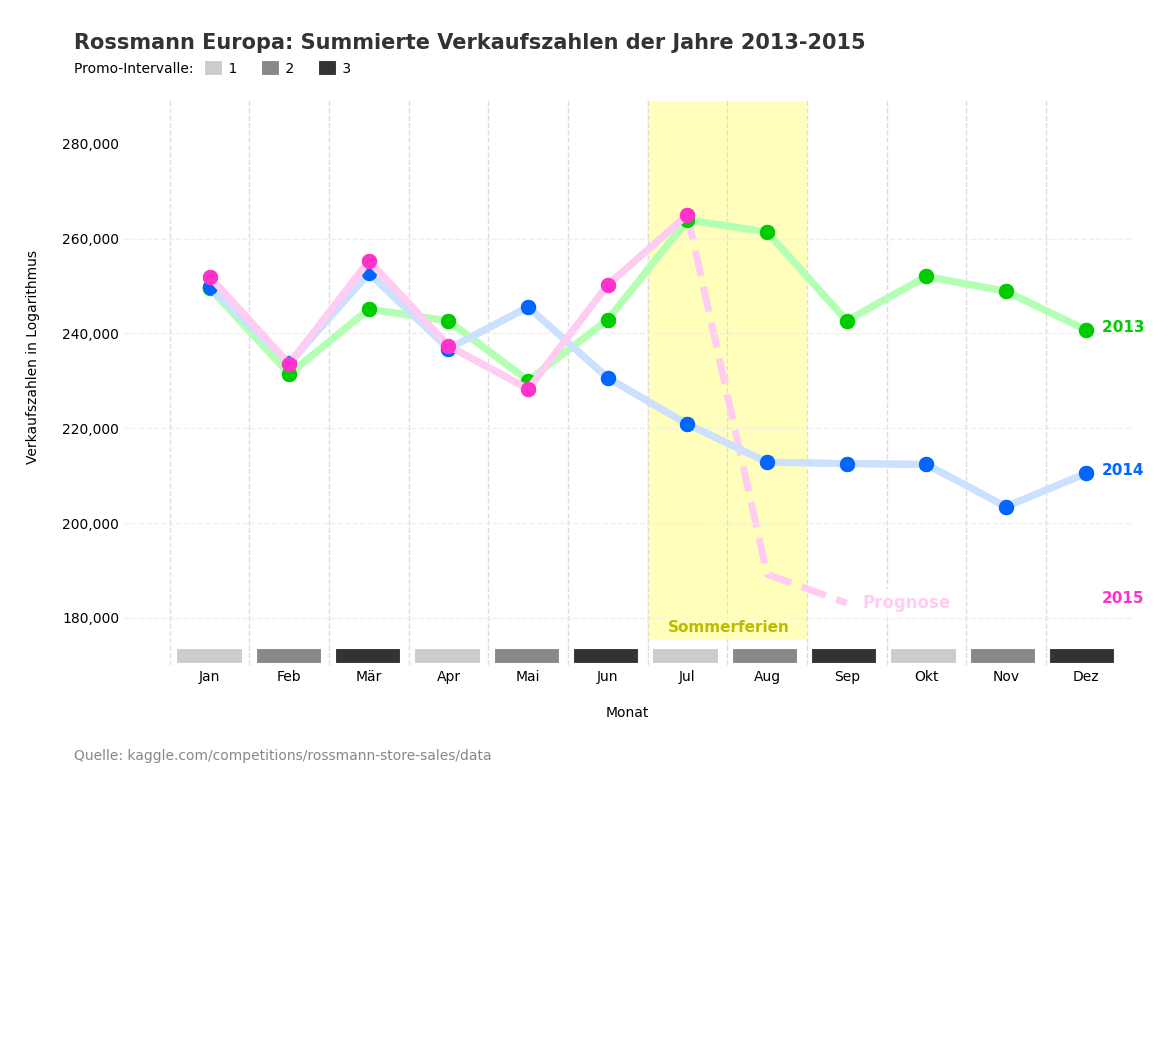

In [75]:
# Plot 1: die monatlichen Verkaufszahlen der Jahre 2013, 2014 und teilweise 2015 (restliche Werte für 2015 werden mit dem Neuronalen Netz und den Daten der test.csv errechnet). Die Monate, in denen ein Promo-Intervall stattfand, sind farblich hervorgehoben
# numpy array aus den Verkaufszahlen je Jahr erstellen (nicht mit e^x verrechnet, da sonst eine Infinity-Warnung erscheint und der Plot leer bleibt) 
nums13 = np.array(big_df["sales"][big_df["year"] == 0].groupby(big_df["month"]).sum().values)
nums14 = np.array(big_df["sales"][big_df["year"] == 1].groupby(big_df["month"]).sum().values)
nums15 = np.array(big_df["sales"][big_df["year"] == 2].groupby(big_df["month"]).sum().values)
nums15_nn = final_test_df["sales_nn"][final_test_df["year"] == 2].groupby(final_test_df["month"]).sum().values
nums15_nn[-1] = nums15_nn[-1]/17*30 # Für 17 Tage sind Daten vorhanden, daher verhältnismäßiges Skalieren
nums15_nn = list(nums15_nn)
nums15_nn.insert(0, nums15[-1])

# Linien für die einzelnen Jahren ausgeben
def plot_lines():
    ax.plot(x_ticks, nums13, color=p1colors_sat[0], linewidth=5, marker='o', markersize=10, markerfacecolor=p1colors[0], markeredgecolor=p1colors[0])
    ax.plot(x_ticks, nums14, color=p1colors_sat[1], linewidth=5, marker='o', markersize=10, markerfacecolor=p1colors[1], markeredgecolor=p1colors[1])
    ax.plot(x_ticks[:7], nums15, color=p1colors_sat[2], linewidth=5, marker='o', markersize=10, markerfacecolor=p1colors[2], markeredgecolor=p1colors[2])

fig, ax = plt.subplots(figsize=(13, 8))
# Rahmen verstecken
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["left"].set_visible(False)

for i in x_ticks:
    ax.axvline(x=i-0.5, color="#dddddd", linestyle="--", linewidth=1, ymax=0.92)

plot_lines()

# Vorhersage von NN ausgeben
ax.plot(x_ticks[6:9], nums15_nn, color=p1colors_sat[2], linewidth=5, linestyle="dashed")

yticks = ax.get_yticks()
for i in yticks[:-1]:
    ax.axhline(y=i, color="#eeeeee", linestyle="--", linewidth=1)

# textformatierung der Y-Ticks mit Tausendertrennung
yticks = [f"{int(i):,}" for i in yticks]
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_labels)
ax.set_yticklabels(yticks)

# Beschriftungen hinzufügen
ax.text(s=" ", x=0, y=91500)
ax.text(s="\nRossmann Europa: Summierte Verkaufszahlen der Jahre 2013-2015", x = -1.7, y = 300000, fontsize=15, fontweight="bold", color="#333333")
ax.text(s="2013    ", x=11.2, y=nums13[-1]-500, fontsize=11, fontweight="bold", color=p1colors[0])
ax.text(s="2014", x=11.2, y=nums14[-1]-300, fontsize=11, fontweight="bold", color=p1colors[1])
ax.text(s="2015", x=11.2, y=nums15_nn[-1], fontsize=11, fontweight="bold", color=p1colors[2])
ax.text(s="Quelle: kaggle.com/competitions/rossmann-store-sales/data", x=-1.7, y=150000, fontsize=10, color="#888888")
ax.set_xlabel("\nMonat")
ax.set_ylabel("\nVerkaufszahlen in Logarithmus\n")
ax.tick_params(axis='x', length=0)
ax.tick_params(axis='y', length=0)

# Promointervalle je Monat anzeigen
promo_key = [1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3]
c = "red"
for i, v in enumerate(promo_key):
        match v:
            case 1:
                c = "#cccccc"
            case 2:
                c = "#888888"
            case 3:
                
                c = "#333333"
        ax.axhline(y=172000, xmin=i*(1/12.7)+0.06, xmax=i*(1/12.7)+0.11, linewidth=10, color=c)

ax.text(s="Promo-Intervalle:        1           2           3", x=-1.7, y=295000)
off = 0.057
ax.axhline(y=296000, linewidth=10, xmin=0.087, xmax=0.09, color="#cccccc")
ax.axhline(y=296000, linewidth=10, xmin=0.087+off, xmax=0.09+off, color = "#888888")
ax.axhline(y=296000, linewidth=10, xmin=0.087+off*2, xmax=0.09+off*2, color = "#333333")
ax.text(s="Prognose", x=8.2, y=182000, fontsize=12, fontweight="bold", color=p1colors_sat[2], bbox=dict(facecolor="white", alpha=0.7, edgecolor="none"))
ax.axvline(x=6.5, ymin=0.17, ymax=0.785, color="#ffffbb", linewidth=115, zorder=0)

# Ferienintervall anzeigen
ax.text(s="Sommerferien", x=5.75, y=177000, color="#bbbb00", fontweight="bold", fontsize=11, bbox=dict(facecolor="#ffffbb", alpha=0.7, edgecolor="none"))
ax.set_ylim(170000, 300000)
plot_lines()
plt.show()

C:\Users\ole\AppData\Local\Temp\ipykernel_9504\937412412.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f"{int(str(i).split('.')[0]):,}" for i in ax.get_yticks()][:-2])
C:\Users\ole\AppData\Local\Temp\ipykernel_9504\937412412.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([f"{int(int(str(i).split('.')[0])/1000)}" for i in ax.get_xticks()])


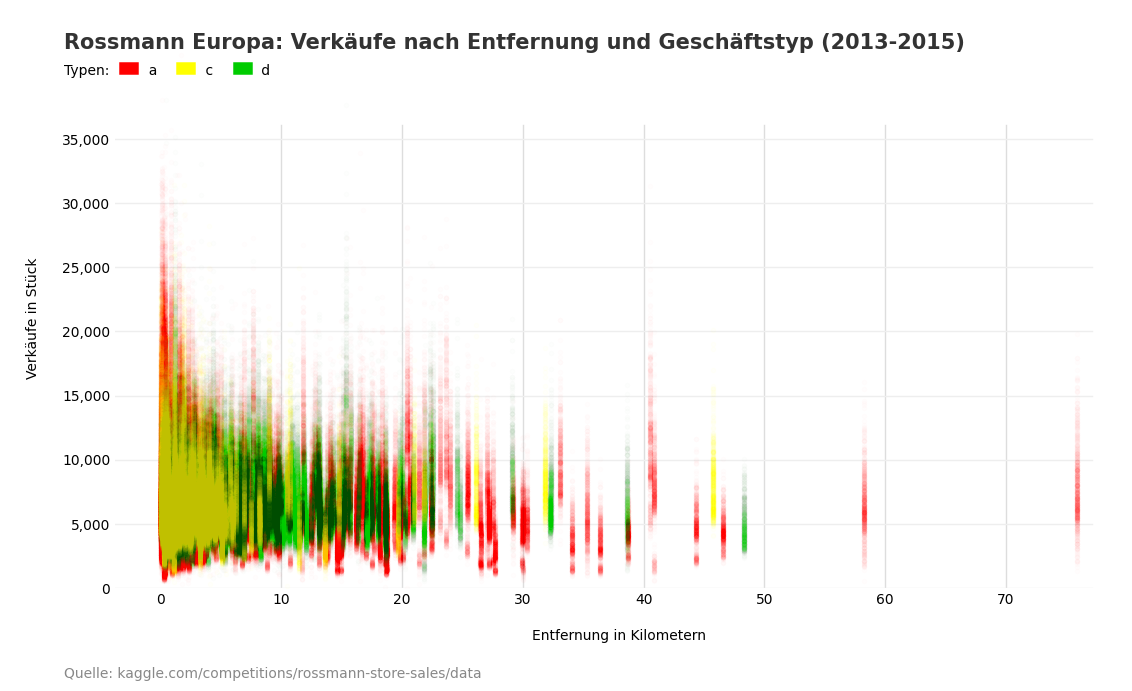

In [44]:
# Plot 2: Scatter-plot mit Entfernungen der Konkurrenzgeschäfte auf der X-Achse und den Verkäufen der jeweiligen Geschäfte auf der Y-Achse. Die Punkte sind farblich nach StoreType unterschieden
a = 0.007
# Nur Werte der 3 Jahre ausgeben, bei denen die Verkaufszahl über 0 liegt
def plot_dots():
    #
    mask = (big_df["store_type"] == 0) & (big_df["sales"] > 0)
    ax.scatter(np.exp(big_df["competition_distance"][mask]), np.exp(big_df["sales"][mask]), c=st_dict[0], s=10, alpha=a, zorder=2)
    mask = (big_df["store_type"] == 3) & (big_df["sales"] > 0)
    ax.scatter(np.exp(big_df["competition_distance"][mask]), np.exp(big_df["sales"][mask]), c=st_dict[3], s=10, alpha=a, zorder=2)
    #mask = (big_df["store_type"] == 1) & (big_df["sales"] > 0)
    #ax.scatter(np.exp(big_df["competition_distance"][mask]), np.exp(big_df["sales"][mask]), c=st_dict[1], s=10, alpha=0.002, zorder=2)  # weg weil keine werte mehr vorhanden
    mask = (big_df["store_type"] == 2) & (big_df["sales"] > 0)
    ax.scatter(np.exp(big_df["competition_distance"][mask]), np.exp(big_df["sales"][mask]), c=st_dict[2], s=10, alpha=a+0.01, zorder=2)

fig, ax = plt.subplots(figsize=(13, 7))
# Rahmen verstecken
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["left"].set_visible(False)
st_dict = {0: "#ff0000", 1: "#000000", 2: "#ffff00", 3: "#00cc00"}
plot_dots()
ax.set_ylim(0, 42000)

# Beschriftung hinzufügen
ax.text(s="\nRossmann Europa: Verkäufe nach Entfernung und Geschäftstyp (2013-2015)", x=-8000, y=42000, fontweight="bold", fontsize=15, color="#333333")
ax.text(s="Typen:         a           c           d", x=-8000, y=40000)
w = 0.007
off = 0.0563
start = 0.01

# Farbschlüssel der Store-Typen in die Legende einfügen
ax.axhline(y=40500, xmin=start, xmax=start+w, linewidth=9, color=st_dict[0])
ax.axhline(y=40500, xmin=start+off, xmax=start+w+off, linewidth=9, color=st_dict[2])
ax.axhline(y=40500, xmin=start+off*2, xmax=start+w+off*2, linewidth=9, color=st_dict[3])

ax.tick_params(axis='x', length=0)
ax.tick_params(axis='y', length=0)

# Achsenbeschriftungen festlegen
ax.set_xlabel("\nEntfernung in Kilometern\n")
ax.set_ylabel("\nVerkäufe in Stück\n")

# Achsen-Tick-Labels formatieren (m -> km, Tausendertrennung)
ax.set_yticklabels([f"{int(str(i).split('.')[0]):,}" for i in ax.get_yticks()][:-2])
ax.set_xticklabels([f"{int(int(str(i).split('.')[0])/1000)}" for i in ax.get_xticks()])
ax.text(s="Quelle: kaggle.com/competitions/rossmann-store-sales/data", x=-8000, y=-7000, fontsize=10, color="#888888")

# Gitternetz
for i in ax.get_xticks()[2:-1]:
    ax.axvline(x=i, ymax=0.86, color="#dddddd", linewidth=1, zorder=1)
for i in ax.get_yticks()[:-2]:
    ax.axhline(y=i, xmax=0.97, color="#eeeeee", linewidth=1, zorder=1)
plt.show()

### Zusammenfassung Grafiken

#### Grafik 1 - Analyse der Verkaufszahlen der Jahre 2013-2015
* Im Vergleich zu 2013 sind die Verkaufzahlen während der Sommerferien in den Folgejahren stark gesunken
#### Grafik 2 - Scatter-Plot mit den Entfernungen der Konkurrenzgeschäfte im Vergleich zu den Verkäufen farblich abgetrennt anhand des Storetypes
* Typ C Geschäfte verkaufen am meisten, wenn die Läden um sie herum weniger als 10km entfernt liegen

# Kaggle Ergebnisse

In [28]:
# Bild aus Dateien anzeigen lassen
from PIL import Image
img = Image.open("nn.png")
img.show()

FileNotFoundError: [Errno 2] No such file or directory: 'nn.png'